In [1]:
import os
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib as plt
import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle as cPickle
import xarray as xr
from datetime import datetime

from driftutils import keep_in_domain as kid
from driftutils.utils import wrap_to_180
from plotutils.drift_map import dm_plot_driftmap_data
from plotutils.map_functions import plot_bathymetry

%matplotlib inline

## Parameters

The observed drifter is one of the spotter drifters

The experiment was run using job scripts stored in: /fs/vnas_Hdfo/dpnm/jeh326/dfo-drift-projection/drift-analysis/jen/general_dwt_tests/jobsub_scripts/OPPVF2F_2023/
- drifteval-sims_nemo_cgrid_opendrift_no_stokes.jgen
- drifteval-sims_nemo_cgrid_opendrift_stokes.jgen

The configs are in the folder: /fs/vnas_Hdfo/dpnm/jeh326/dfo-drift-projection/drift-tool/examples/DriftEval/
- /simulations/config_de-sims_nemo_cgrid_opendrift_no_waves.yaml
- /simulations/backup_config_de-sims_nemo_cgrid_opendrift_waves.yaml
- /analysis/config_de-ana_user_comparison_crop_OPPVF2F_2023.yaml
- /analysis/config_de-ana_user_comparison_plotting_OPPVF2F_2023.yaml

## Plotting functions

In [2]:
def set_up_map_plot(ax):
    ax.add_feature(cfeature.LAND.with_scale('10m'),
                   facecolor="lightgrey",
                   edgecolor='black',
                   linewidth=0.2,
                   alpha=1.0,
                   zorder=0)
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'),
                   edgecolor='black',
                   linewidth=0.1,
                   alpha=1.0,
                   zorder=1)
    ax.gridlines(crs=crs.PlateCarree(),
                 draw_labels=['bottom', 'left'],
                 xformatter=LongitudeFormatter(),
                 xlabel_style={'rotation': 45, 'ha': 'center'},
                 yformatter=LatitudeFormatter(),
                 ylabel_style={'rotation': 45, 'ha': 'center'},
                 linewidth=2, color='gray', alpha=0.1, 
                 linestyle='-', zorder=1)
    return ax

def create_subplots_figure(nrows=1, ncols=1, map=False, fsize=None, ratio=1.5, axsize=6):
    """ratio is expected to be width/height so that a ratio of 2 will
    give a plot that is twice as wide as it is tall"""
    
    if not fsize:
        fsize = (ratio*(axsize*nrows), axsize*ncols)
    if map:
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, figsize=fsize,
                                subplot_kw={'projection': crs.PlateCarree()})
    else:
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, figsize=fsize)
    return fig, axs.flatten()

def plot_obs_track(ds, 
                   savedir, 
                   axsize=None, 
                   lab='_no_label_', 
                   bbox=None, 
                   exp_bbox=None, 
                   last_point=None, 
                   etopo=None, 
                   savename='obs.png'):
    
    fig, axs = create_subplots_figure(nrows=1, ncols=1, map=True, axsize=axsize)
    ax = axs[0]
    set_up_map_plot(ax)
    
    #len_lons = 2438
    if last_point is None:
        last_point = len(ds.LONGITUDE.values)
    lons = ds.LONGITUDE.values[0:last_point]
    lats = ds.LATITUDE.values[0:last_point]
    
    ax.plot(lons, lats, color='black', linestyle='-', linewidth=1, label=lab)
    ax.plot(lons[0], lats[0], 'o', color='green', markersize=3)
    
    if etopo is not None:
        plot_bathymetry(ax, bbox, bathymetry_file=etopo, fig=fig)
    
    if bbox:
        ax.set_extent(bbox)
    
    if exp_bbox:
        minlon, maxlon, minlat, maxlat = exp_bbox
        exp_bbox_lons = [maxlon, minlon, minlon, maxlon, maxlon]
        exp_bbox_lats = [maxlat, maxlat, minlat, minlat, maxlat]
        ax.plot(exp_bbox_lons, exp_bbox_lats, color='red', linestyle='-', linewidth=0.5)
    
    plt.legend()
    plt.savefig(os.path.join(savedir, savename))
    
    
def plot_all_track(ds, exp, savedir, axsize=None, lab='_no_label_', bbox=None, exp_bbox=None, last_point=None, etopo=None):
    
    fig, axs = create_subplots_figure(nrows=1, ncols=1, map=True, axsize=axsize)
    ax = axs[0]
    set_up_map_plot(ax)
        
    if etopo is not None:
        plot_bathymetry(ax, bbox, bathymetry_file=etopo, fig=fig)
    
    obslab = [lab if lab is not None else 'observed drifters'][0]
    labnames = {'stokes': 'Including Waves', 'no_stokes': 'Not Including Waves', 'obs': obslab}
    plotcols = {'stokes': 'red', 'no_stokes': 'blue', 'obs': 'black'}
    
    for sname in exp.setname.values:
        exp_set = exp.where(exp.setname == sname, drop=True)
        for mrun in exp_set.model_run.values:
            exp_use = exp_set.where(exp.model_run == mrun, drop=True)
            mlons = exp_use.mod_lon.values[0][0]
            mlats = exp_use.mod_lat.values[0][0]
            mlab='_no_label_'
            if mrun == 0:
                mlab = labnames[sname]
            ax.plot(mlons, mlats, color=plotcols[sname], linestyle='-', linewidth=0.5, label=mlab)
            if sname == 'stokes':
                olons = exp_use.obs_lon.values[0][0]
                olats = exp_use.obs_lat.values[0][0]
                olab='_no_label_'
                if mrun == 0:
                    olab = labnames['obs']
                ax.plot(olons, olats, color=plotcols['obs'], linestyle='-', linewidth=0.5, label=olab)
                
    if exp_bbox:
        minlon, maxlon, minlat, maxlat = exp_bbox
        exp_bbox_lons = [maxlon, minlon, minlon, maxlon, maxlon]
        exp_bbox_lats = [maxlat, maxlat, minlat, minlat, maxlat]
        ax.plot(exp_bbox_lons, exp_bbox_lats, color='red', linestyle='-', linewidth=0.5)
                
    if bbox:
        ax.set_extent(bbox)
    
    h, l = ax.get_legend_handles_labels()
    plt.legend([h[2], h[1], h[0]], [l[2], l[1], l[0]])
    plt.savefig(os.path.join(savedir, 'with-tracks_SPOT1017D2021120609.png'))

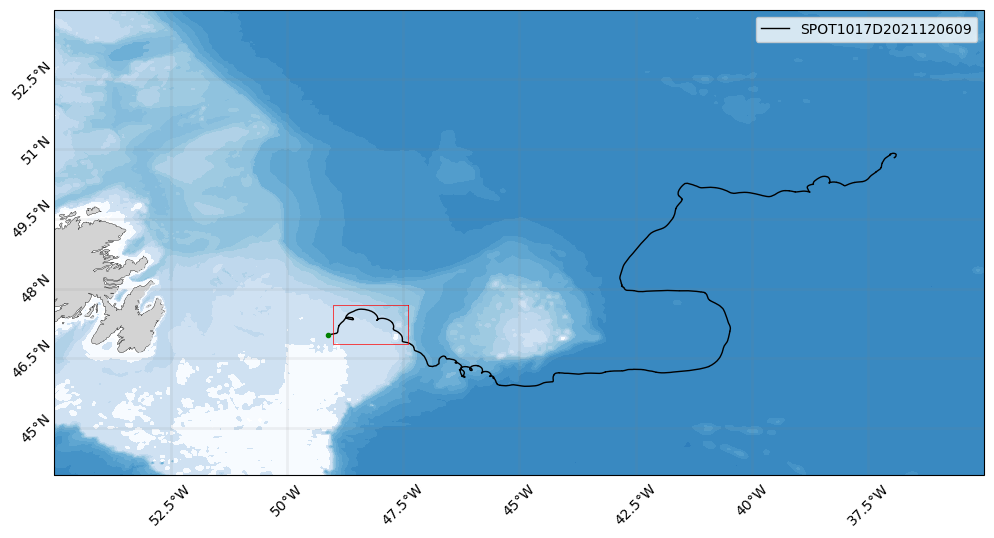

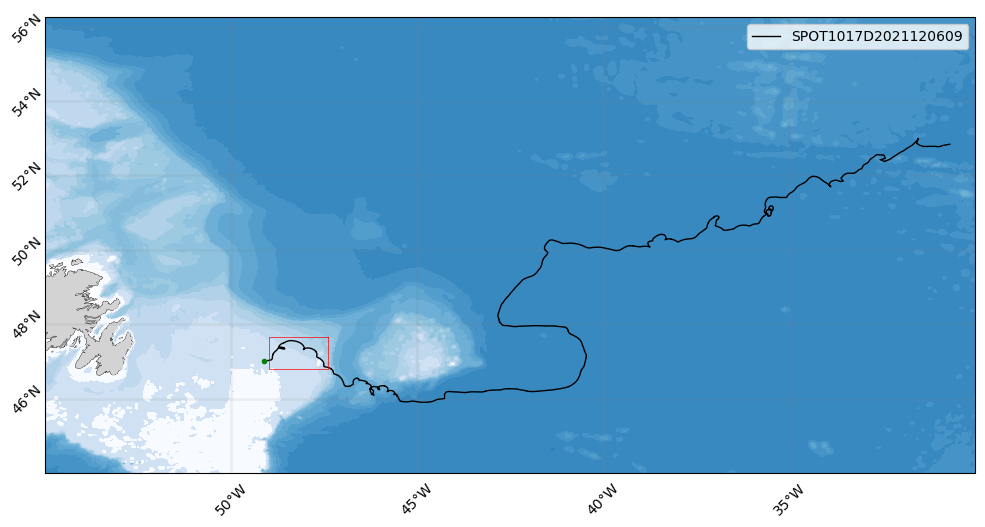

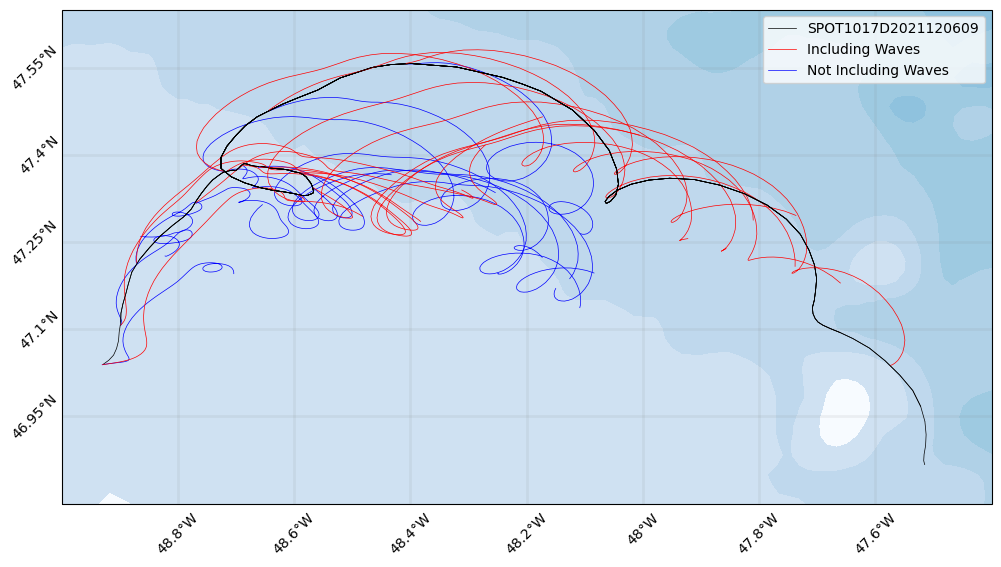

In [4]:
savedir = "/gpfs/fs7/dfo/dpnm/jeh326/projects/OPPVF2F_2023/output/spotter_rerun_jup/"
etopo_file = "/home/sdfo000/sitestore7/opp_drift_fa3/software/misc_files/ETOPO1_Bed_g_gmt4.grd"
obsdir = "/gpfs/fs7/dfo/dpnm/jeh326/projects/stokes_drift/input_data/obs_drifters/netcdf_2023-01-17"
obs = xr.load_dataset(os.path.join(obsdir, 'SPOT1017D2021120609.nc'))
expdir = "/gpfs/fs7/dfo/dpnm/jeh326/projects/OPPVF2F_2023/output/cropped_output/"
exp = xr.load_dataset(os.path.join(expdir, 'SPOT1017D2021120609_comparison.nc'))
exp_bbox = [-49, -47.4, 46.8, 47.65]

plot_obs_track(obs, 
               savedir, 
               axsize=8, 
               lab='SPOT1017D2021120609', 
               bbox=[-55, -35, 44, 54], 
               exp_bbox=exp_bbox, 
               last_point=1800, 
               etopo=etopo_file,
               savename='obs_SPOT1017D2021120609.png')

plot_obs_track(obs, 
               savedir, 
               axsize=8, 
               lab='SPOT1017D2021120609', 
               bbox=[-55, -30, 44, 56], 
               exp_bbox=exp_bbox, 
               #last_point=1800, 
               etopo=etopo_file,
               savename='obs_SPOT1017D2021120609_full-track.png')

plot_all_track(obs, exp,
               savedir, 
               axsize=8, 
               lab='SPOT1017D2021120609', 
               bbox=exp_bbox,
               etopo=etopo_file)